## Time series Forecasting de US 10 YEAR BONDS usando modelos no lineales
Notebook para predecir el rendimiento de los bonos americanos a 10 años mediante modelos de machine learning no lineales. Los datos con los que vamos a trabajar son la serie temporal diaria de rendimientos de los bonos de los EEUU a 10 años con un horizonte temporal de 14 años (desde el 2010 hasta el 2024) 
### Modelos no lineales del notebook:
1. Modelo LSTM (Long Short Term Model)
2. Modelo XGBoost
3. Modelo RNN (Red Neuronal Recurrente)

La metodología empleada para cada uno de los modelos es la siguiente: primero se predicen los rendimientos de los bonos para el conjunto de validación y se calcula el error (MSE), luego se ajustan los parámetros mediante grid search y se vuelve a realizar el mismo proceso anterior, después se predicen los rendimientos de los bonos para el conjunto de prueba (test) y se calcula el error (MSE) y por ultimo se evalúa el rendimiento final del modelo por backtesting 

### Librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelado y Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap
shap.initjs()

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"Versión skforecast: {skforecast.__version__}")
print(f"Versión lightgbm: {lightgbm.__version__}")
print(f"Versión scikit-learn: {sklearn.__version__}")

Versión skforecast: 0.12.0
Versión lightgbm: 4.3.0
Versión scikit-learn: 1.5.0


### Lectura de la serie temporal

In [2]:
# Lectura de los datos de la Serie temporal del precio de los bonos americanos a 10 años

df = pd.read_csv('10-year-treasury-bond-rate-yield-chart.csv')

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.asfreq('d')
df = df.loc["2010-01-04 00:00:00":]
df = df.asfreq('d')
#Sustitumos los valores nulos por el valor inmediatamente anterior no nulo
df = df.fillna(method='ffill')
display(df.head(4))

,value
date,
2010-01-04,3.85
2010-01-05,3.77
2010-01-06,3.85
2010-01-07,3.85


### Separación del conjunto de datos en train/validation/test

Fechas train      : 2010-01-04 00:00:00 --- 2020-01-01 00:00:00  (n=3650)
Fechas validacion : 2020-01-02 00:00:00 --- 2022-10-31 00:00:00  (n=1034)
Fechas test       : 2022-11-01 00:00:00 --- 2024-04-19 00:00:00  (n=536)


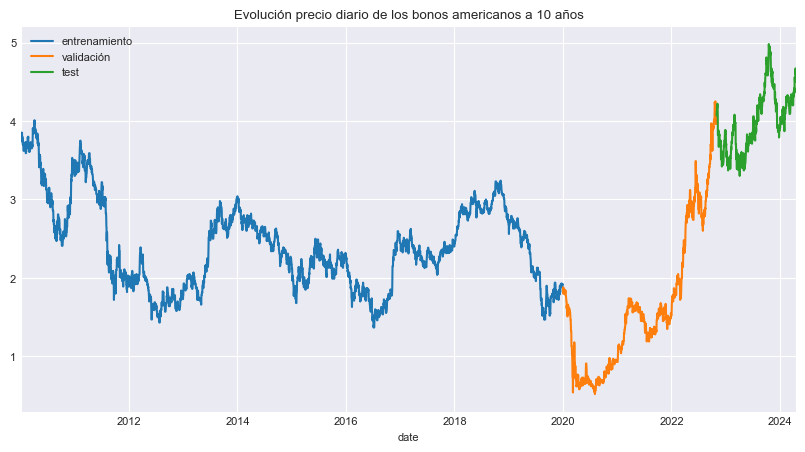

In [3]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2020-01-01 23:59:59'
fin_validacion = '2022-10-31 23:59:59'
datos_train = df.loc[: fin_train, :].copy()
datos_val   = df.loc[fin_train:fin_validacion, :].copy()
datos_test  = df.loc[fin_validacion:, :].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# Gráfico
# ======================================================================================

df_series = df.squeeze()
fig, ax = plt.subplots(figsize=(10, 5))
df_series.loc[:fin_train].plot(ax=ax, label='entrenamiento')
df_series.loc[fin_train:fin_validacion].plot(ax=ax, label='validación')
df_series.loc[fin_validacion:].plot(ax=ax, label='test')
ax.set_title('Evolución precio diario de los bonos americanos a 10 años')
ax.legend();

### Análisis exploratorio inicial

#### Gráficos de autocorrelación y autocorrelación parcial

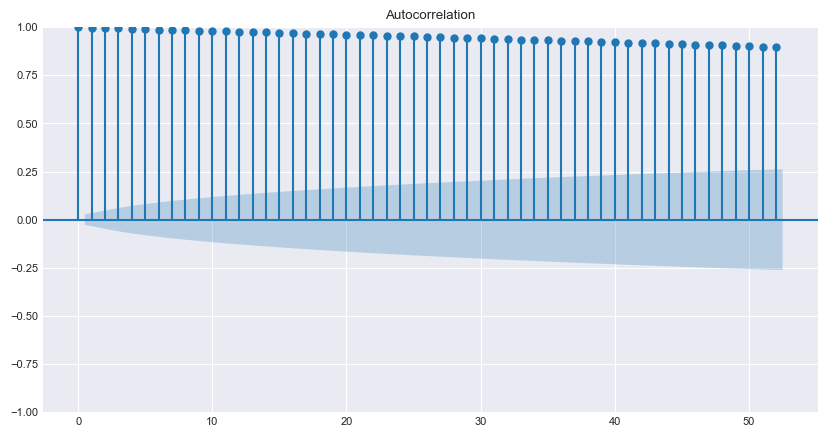

In [35]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df, ax=ax, lags=52)
plt.show()

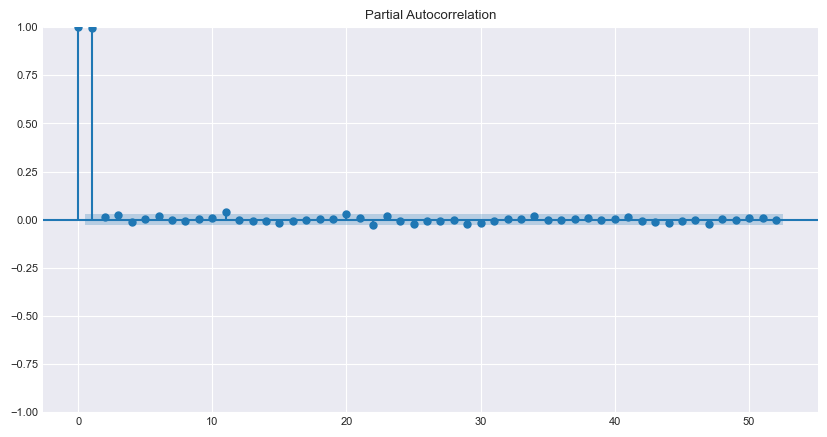

In [36]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df, ax=ax, lags=52, method='ywm')
plt.show()

#### Estudio de los componentes de la serie temporal: tendencia, estacionalidad y error

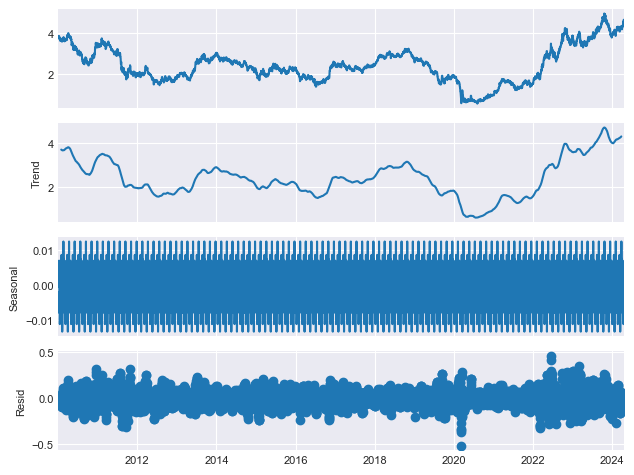

In [38]:
## Descomposición de la serie original en sus componentes: tendencia, estacionalidad y residuo
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion_aditiva = seasonal_decompose(df, model='additive', period=52)
descomposicion_aditiva.plot()
plt.show()

## 1. Modelo LSTM

### Creación del modelo, predicción para el conjunto de validación y cálculo del MSE

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Error de validación (mse): 0.0004753027377857336


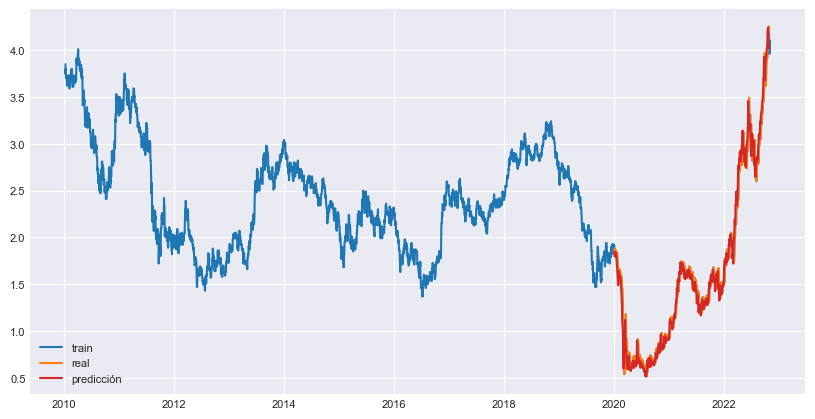

In [12]:
# Vamos a crear un modelo de forecasting de time series con un modelo no lineal de machine learning como Lstms, xgboost, 

# Modelo de forecasting con Lstm (Long Short Term Memory). Se trata de una red neuronal recurrente que se utiliza para predecir series temporales y que es capaz de recordar información a largo plazo.
# ==============================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor

# Escalado de los datos
# ==============================================================================
scaler = MinMaxScaler(feature_range=(0, 1))
serie_train = df.loc[:fin_train].squeeze().values.reshape(-1, 1)
serie_train_scaled = scaler.fit_transform(serie_train)

# División de los datos en secuencias
# ==============================================================================
def secuencias_entrada(secuencia, pasos):
    """ Función que divide una secuencia en múltiples secuencias más pequeñas
    """
    X, y = [], []
    for i in range(len(secuencia)):
        # índices de fin de la secuencia
        fin_seq = i + pasos
        # comprobar si nos hemos salido de la secuencia
        if fin_seq > len(secuencia)-1:
            break
        # obtener la secuencia de entrada y añadir al conjunto X
        seq_x = secuencia[i:fin_seq]
        X.append(seq_x)
        # obtener el valor que sigue a la secuencia y añadirlo a y
        seq_y = secuencia[fin_seq]
        y.append(seq_y)
    return np.array(X), np.array(y)

# Definición de la secuencia de entrada
pasos = 7
X_train, y_train = secuencias_entrada(serie_train_scaled, pasos)

# Creación del modelo
# ==============================================================================
def crear_modelo(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = KerasRegressor(dropout_rate=0.2, units= 50, build_fn=crear_modelo, verbose=0)

# Entrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predicciones
# ==============================================================================
serie_val = datos_val.squeeze().values.reshape(-1, 1)
serie_val_scaled = scaler.transform(serie_val)

X_val, y_val = secuencias_entrada(serie_val_scaled, pasos)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.loc[:fin_validacion].index[pasos:], df.loc[:fin_validacion].values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

### Ajuste de hiperparámetros del modelo LSTM

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Mejores parámetros: {'batch_size': 32, 'epochs': 100}
Mejor resultado - MSE: 0.9922695115165643


``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Error de validación (mse): 0.00040528760848297874


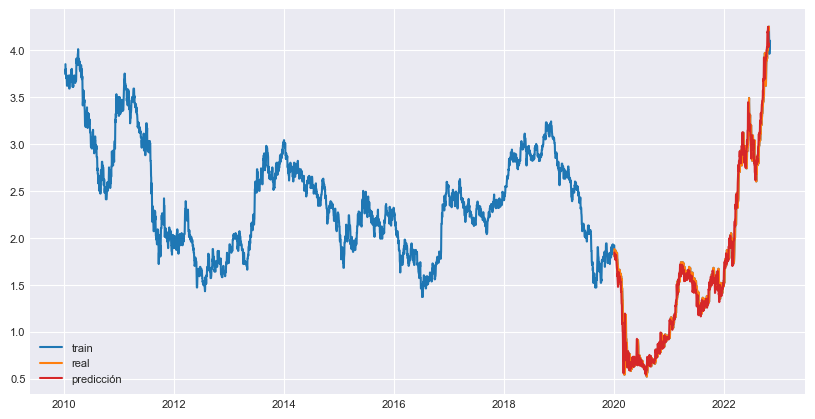

In [13]:
# Grid search de hiperparámetros LSTM
# ==============================================================================
from sklearn.model_selection import GridSearchCV


model = KerasRegressor(dropout_rate=0.2, units= 50, build_fn=crear_modelo, verbose=0)

param_grid = {'batch_size': [32, 64], 
                'epochs': [50, 100]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2) 

# Escalado de los datos
# ==============================================================================
scaler = MinMaxScaler(feature_range=(0, 1))
serie_train = datos_train.squeeze().values.reshape(-1, 1)
serie_train_scaled = scaler.fit_transform(serie_train)

# Definición de la secuencia de entrada
pasos = 7
X_train, y_train = secuencias_entrada(serie_train_scaled, pasos)

# Definición de la secuencia de entrada para los datos de validación
serie_val = datos_val.squeeze().values.reshape(-1, 1)
serie_val_scaled = scaler.transform(serie_val)
X_val, y_val = secuencias_entrada(serie_val_scaled, pasos)

# Ajuste del modelo y búsqueda de hiperparámetros
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Resultados
# ==============================================================================
print(f"Mejores parámetros: {grid_result.best_params_}") 
print(f"Mejor resultado - MSE: {grid_result.best_score_}") # Este es el MSE de los datos de entrenamiento con el mejor modelo

# Predicciones con el mejor modelo
model = grid_result.best_estimator_
model.fit(X_train, y_train, validation_data=(X_val, y_val))
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.loc[:fin_validacion].index[pasos:], df.loc[:fin_validacion].values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

### Predicción con el conjunto de test y cálculo del MSE

Error de prueba (mse): 0.000645794419464906


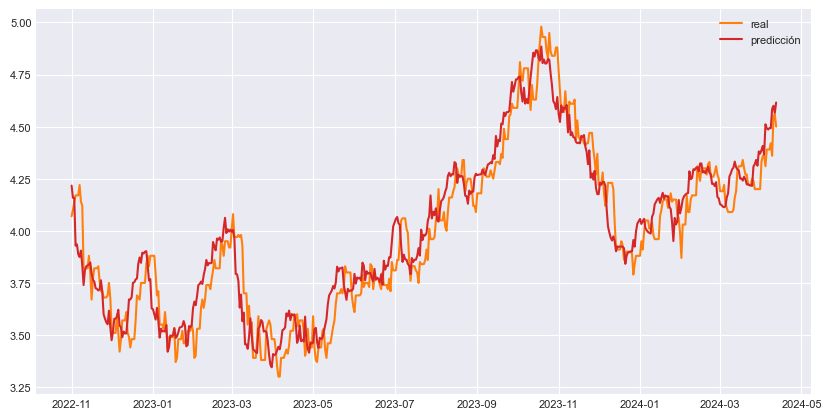

In [14]:
# Evaluación del rendimiento final del modelo LSTM (hiperparámetros ajustados) utilizando el conjunto de prueba.

# Definición de la secuencia de entrada para los datos de prueba
serie_test = datos_test.squeeze().values.reshape(-1, 1)
serie_test_scaled = scaler.transform(serie_test)
X_test, y_test = secuencias_entrada(serie_test_scaled, pasos)

# Predicciones con el mejor modelo en los datos de prueba
preds_test_scaled = model.predict(X_test)
preds_test = scaler.inverse_transform(preds_test_scaled)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_test.index[:len(preds_test)], datos_test.values[:len(preds_test)], label='real', color='tab:orange')
ax.plot(datos_test.index[:len(preds_test)], preds_test, label='predicción', color='tab:red')
ax.legend();

# Error de prueba
error_test = mean_squared_error(y_test, preds_test_scaled)
print(f"Error de prueba (mse): {error_test}")

### Backtesting con el modelo LSTM

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 4684
Number of observations used for backtesting: 536
    Number of folds: 536
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-01 00:00:00 -- 2022-11-01 00:00:00  (n=1)
Fold: 1
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-02 00:00:00 -- 2022-11-02 00:00:00  (n=1)
Fold: 2
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-03 00:00:00 -- 2022-11-03 00:00:00  (n=1)
Fold: 3
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-04 00:00:00 -- 2022-11-04 00:00:00  (n=1)
Fold: 4
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-05 00:00:00 

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/536 [00:00<?, ?it/s]

Error de backtest (mse): 0.024341178342415917


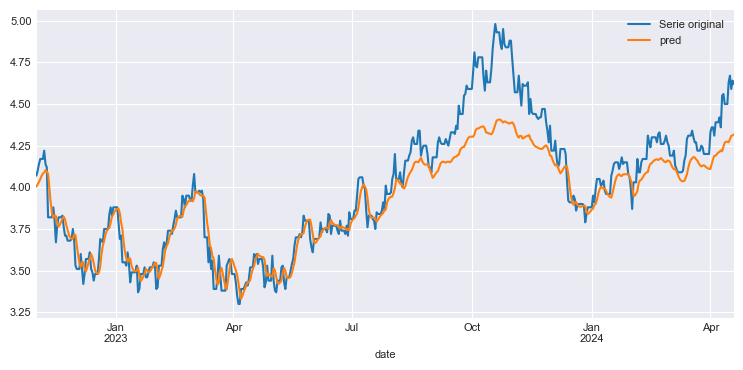

In [15]:
# Backtesting del mejor modelo LSTM
# ==============================================================================
from skforecast.model_selection import backtesting_forecaster

# Crear objeto forecaster
forecaster = ForecasterAutoreg(
                    regressor = model,
                    lags     = pasos
                )

# Backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = df.squeeze(),
                                        initial_train_size = len(df.loc[:fin_validacion]),
                                        steps     = 1,
                                        metric    = 'mean_squared_error',
                                        verbose   = True
                                  )

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df_test_series = datos_test.squeeze()
df_test_series.plot(ax=ax, label='Serie original')
predicciones_backtest.plot(ax=ax, label='Predicciones backtest')
ax.legend();

# Error de backtest
# ==============================================================================
print(f"Error de backtest (mse): {metrica}")

## 2. Modelo XGBoost

### Creación del modelo, predicción para el conjunto de validación y cálculo del MSE

Error de validación (mse): 0.02768757203439426


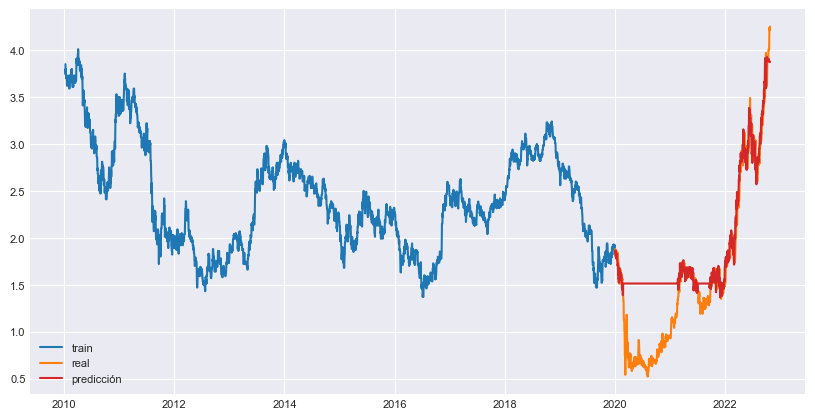

In [27]:
# Modelo de forecasting con Xgboost. Se trata de un algoritmo de boosting que se utiliza para predecir series temporales y que es capaz de recordar información a largo plazo. 
# ==============================================================================
from xgboost import XGBRegressor

# Definición de la secuencia de entrada
pasos = 7
X_train, y_train = secuencias_entrada(serie_train_scaled, pasos)

# Cambiamos la forma de X_train a una matriz bidimensional
X_train = X_train.reshape(X_train.shape[0], -1)

# Creación del modelo
# ==============================================================================
model = XGBRegressor(objective='reg:squarederror')

# Entrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train)

# Predicciones
# ==============================================================================
serie_val = datos_val.squeeze().values.reshape(-1, 1)
serie_val_scaled = scaler.transform(serie_val)

X_val, y_val = secuencias_entrada(serie_val_scaled, pasos)
X_val = X_val.reshape(X_val.shape[0], -1)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1))

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_train.index[pasos:], datos_train.values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
# ==============================================================================
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

### Ajuste de hiperparámetros

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores parámetros: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Mejor resultado - MSE: 0.9677230000748388
Error de validación (mse): 0.024776265843284375


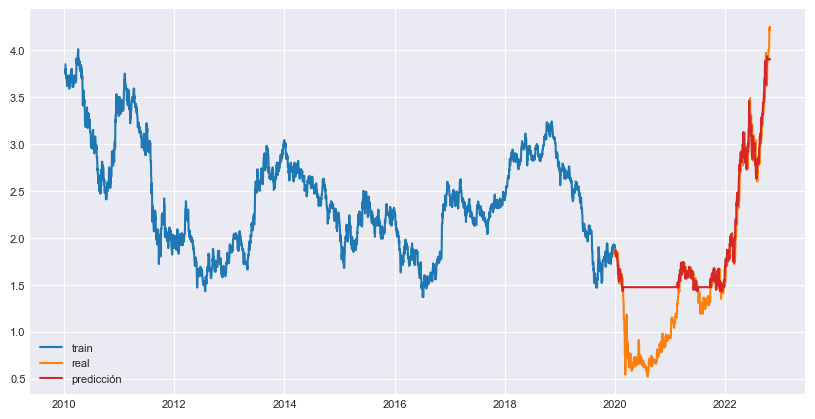

In [24]:
# Búsqueda de hiperparámetros Xgboost
# ==============================================================================
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

model = XGBRegressor(objective='reg:squarederror')
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Ajuste del modelo y búsqueda de hiperparámetros
grid_result = grid.fit(X_train, y_train)

# Resultados
# ==============================================================================
print(f"Mejores parámetros: {grid_result.best_params_}")
print(f"Mejor resultado - MSE: {grid_result.best_score_}")

# Predicciones con el mejor modelo
model = grid_result.best_estimator_
model.fit(X_train, y_train)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1))

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_train.index[pasos:], datos_train.values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
# ==============================================================================
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")



### Predicción con el conjunto de test y cálculo del MSE

Error de prueba (mse): 0.016617867083021796


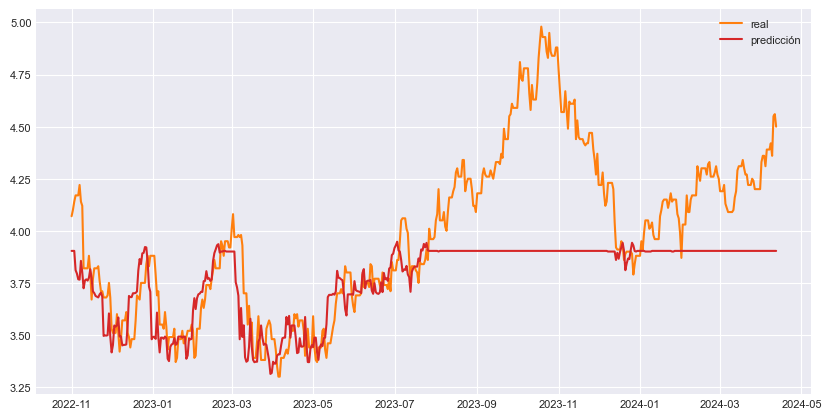

In [25]:
# Evaluación del rendimiento final del modelo Xgboost (hiperparámetros ajustados) utilizando el conjunto de prueba.
# ==============================================================================
serie_test = datos_test.squeeze().values.reshape(-1, 1)
serie_test_scaled = scaler.transform(serie_test)
X_test, y_test = secuencias_entrada(serie_test_scaled, pasos)
X_test = X_test.reshape(X_test.shape[0], -1)

# Predicciones con el mejor modelo en los datos de prueba
preds_test_scaled = model.predict(X_test)
preds_test = scaler.inverse_transform(preds_test_scaled.reshape(-1, 1))

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_test.index[:len(preds_test)], datos_test.values[:len(preds_test)], label='real', color='tab:orange')
ax.plot(datos_test.index[:len(preds_test)], preds_test, label='predicción', color='tab:red')
ax.legend();

# Error de prueba
# ==============================================================================
error_test = mean_squared_error(y_test, preds_test_scaled)
print(f"Error de prueba (mse): {error_test}")



### Backtesting del modelo XGBoost

Information of backtesting process
----------------------------------
Number of observations used for initial training: 4684
Number of observations used for backtesting: 536
    Number of folds: 536
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-01 00:00:00 -- 2022-11-01 00:00:00  (n=1)
Fold: 1
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-02 00:00:00 -- 2022-11-02 00:00:00  (n=1)
Fold: 2
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-03 00:00:00 -- 2022-11-03 00:00:00  (n=1)
Fold: 3
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-04 00:00:00 -- 2022-11-04 00:00:00  (n=1)
Fold: 4
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-05 00:00:00 

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/536 [00:00<?, ?it/s]

Error de backtest (mse): 0.08116967219926965


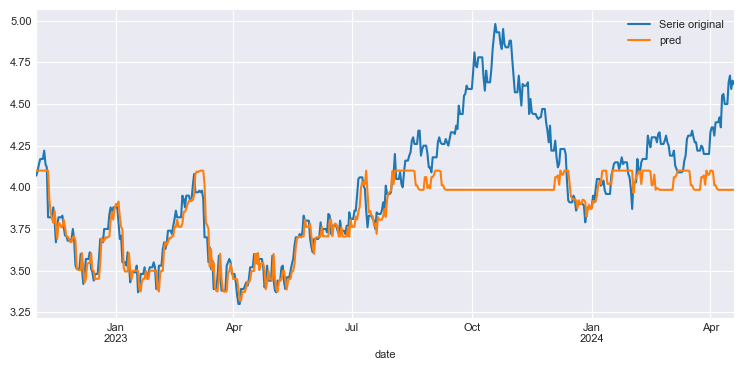

In [26]:
# Backtesting del mejor modelo Xgboost
# ==============================================================================
# Crear objeto forecaster
forecaster = ForecasterAutoreg(
                    regressor = model,
                    lags     = pasos
                )

# Backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = df.squeeze(),
                                        initial_train_size = len(df.loc[:fin_validacion]),
                                        steps     = 1,
                                        metric    = 'mean_squared_error',
                                        verbose   = True
                                  )

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df_test_series = datos_test.squeeze()
df_test_series.plot(ax=ax, label='Serie original')
predicciones_backtest.plot(ax=ax, label='Predicciones backtest')
ax.legend();

# Error de backtest
# ==============================================================================
print(f"Error de backtest (mse): {metrica}")



## 3. Modelo RNN

### Creación del modelo, predicción para el conjunto de validación y cálculo del MSE

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0409
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0064
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0038
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 11/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 12/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 13/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 14/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 15/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1

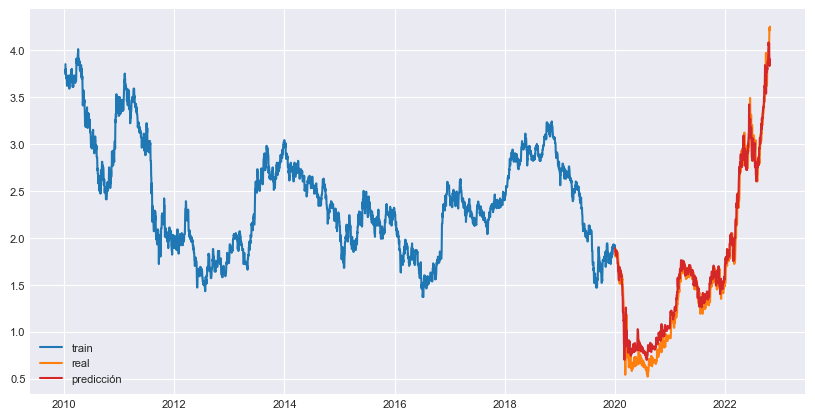

In [21]:
# Modelo de forecasting con Redes Neuronales de Retroalimentación (RNN). Aunque LSTM es una variante de las RNN, las redes neuronales recurrentes simples también pueden ser efectivas para capturar relaciones temporales en datos de series temporales
# ==============================================================================
from tensorflow.keras.layers import SimpleRNN

# Creación del modelo
# ==============================================================================
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predicciones
# ==============================================================================
serie_val = datos_val.squeeze().values.reshape(-1, 1)
serie_val_scaled = scaler.transform(serie_val)

X_val, y_val = secuencias_entrada(serie_val_scaled, pasos)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_train.index[pasos:], datos_train.values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
# ==============================================================================
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

### Ajuste de hiperparámetros

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Mejores parámetros: {'batch_size': 32, 'epochs': 100}
Mejor resultado - MSE: 0.9920221525442406


``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Error de validación (mse): 0.0011316306273035151


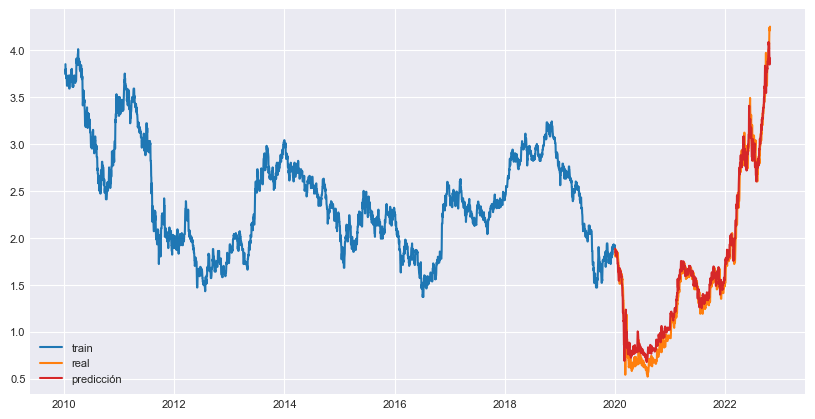

In [23]:
def crear_modelo(units, dropout_rate):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Búsqueda de hiperparámetros RNN
# ==============================================================================
model = KerasRegressor(dropout_rate=0.2, units= 50, build_fn=crear_modelo, verbose=0)

param_grid = {'batch_size': [32, 64],
                'epochs': [50, 100]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Ajuste del modelo y búsqueda de hiperparámetros
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Resultados
# ==============================================================================
print(f"Mejores parámetros: {grid_result.best_params_}")
print(f"Mejor resultado - MSE: {grid_result.best_score_}")

# Predicciones con el mejor modelo
model = grid_result.best_estimator_
model.fit(X_train, y_train, validation_data=(X_val, y_val))
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_train.index[pasos:], datos_train.values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
# ==============================================================================
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")


### Predicción con el conjunto de test y cálculo del MSE

Error de prueba (mse): 0.0032931618272477132


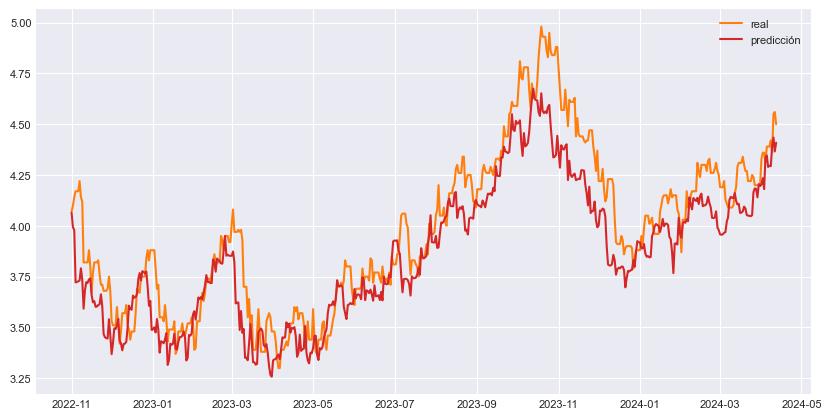

In [25]:
# Evaluación del rendimiento final del modelo RNN (hiperparámetros ajustados) utilizando el conjunto de prueba.
# ==============================================================================
serie_test = datos_test.squeeze().values.reshape(-1, 1)
serie_test_scaled = scaler.transform(serie_test)
X_test, y_test = secuencias_entrada(serie_test_scaled, pasos)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicciones con el mejor modelo en los datos de prueba
preds_test_scaled = model.predict(X_test)
preds_test = scaler.inverse_transform(preds_test_scaled)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_test.index[:len(preds_test)], datos_test.values[:len(preds_test)], label='real', color='tab:orange')
ax.plot(datos_test.index[:len(preds_test)], preds_test, label='predicción', color='tab:red')
ax.legend();

# Error de prueba
# ==============================================================================
error_test = mean_squared_error(y_test, preds_test_scaled)
print(f"Error de prueba (mse): {error_test}")

### Backtesting del modelo RNN

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 4684
Number of observations used for backtesting: 536
    Number of folds: 536
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-01 00:00:00 -- 2022-11-01 00:00:00  (n=1)
Fold: 1
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-02 00:00:00 -- 2022-11-02 00:00:00  (n=1)
Fold: 2
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-03 00:00:00 -- 2022-11-03 00:00:00  (n=1)
Fold: 3
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-04 00:00:00 -- 2022-11-04 00:00:00  (n=1)
Fold: 4
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-05 00:00:00 

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/536 [00:00<?, ?it/s]

Error de backtest (mse): 0.07420171884286253


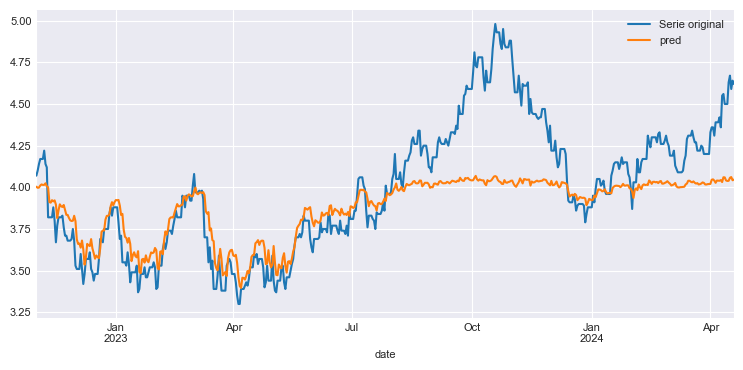

In [26]:
# Backtesting del mejor modelo RNN
# ==============================================================================
# Crear objeto forecaster
forecaster = ForecasterAutoreg(
                    regressor = model,
                    lags     = pasos
                )

# Backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = df.squeeze(),
                                        initial_train_size = len(df.loc[:fin_validacion]),
                                        steps     = 1,
                                        metric    = 'mean_squared_error',
                                        verbose   = True
                                  )

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df_test_series = datos_test.squeeze()
df_test_series.plot(ax=ax, label='Serie original')
predicciones_backtest.plot(ax=ax, label='Predicciones backtest')
ax.legend();

# Error de backtest
# ==============================================================================
print(f"Error de backtest (mse): {metrica}")